**Paso 1: Evaluación del modelo binario**

Found 1732 images belonging to 2 classes.
Total de imágenes en el conjunto de prueba: 1732
55/55 [==============================] - 3s 35ms/step - loss: 0.3672 - accuracy: 0.8620 - precision_13: 0.8306 - recall_13: 0.8364 - auc_13: 0.9371

Resultados de evaluación en el conjunto de prueba:
Precisión (Accuracy): 0.8620
Recall: 0.8364
Precision: 0.8306
AUC: 0.9371
55/55 [==============================] - 2s 36ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

   No Lesion       0.88      0.88      0.88      1017
      Lesion       0.83      0.84      0.83       715

    accuracy                           0.86      1732
   macro avg       0.86      0.86      0.86      1732
weighted avg       0.86      0.86      0.86      1732



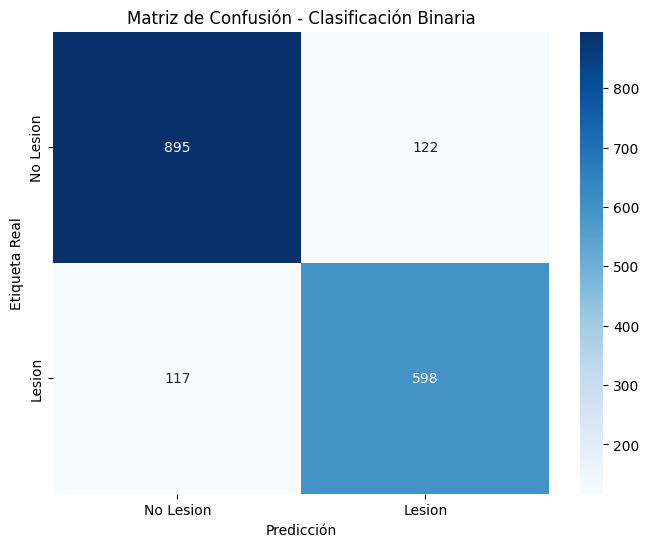

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el modelo binario
binary_model = tf.keras.models.load_model('modelosFinales/movileNet_clasificacionBinaria.keras', compile=False)
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Directorio de prueba
test_dir = 'imagenes_divididas/test'

# Configuración del generador de imágenes para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']  # Usar las clases correspondientes
)

# Verificar cantidad de imágenes en el conjunto de prueba
print(f"Total de imágenes en el conjunto de prueba: {test_generator.samples}")

# Evaluar el modelo binario en el conjunto de prueba
evaluation_metrics = binary_model.evaluate(test_generator)
test_loss, test_acc, test_precision, test_recall, test_auc = evaluation_metrics

print("\nResultados de evaluación en el conjunto de prueba:")
print(f"Precisión (Accuracy): {test_acc:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"AUC: {test_auc:.4f}")

# Generar predicciones y etiquetas verdaderas
y_pred_prob = binary_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes  # Etiquetas reales del generador

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=['No Lesion', 'Lesion']))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

**Paso 2: Evaluación del modelo de clasificación multicategoría**

Found 1732 images belonging to 2 classes.
55/55 [==============================] - 3s 41ms/step
Evaluación del modelo binario (Lesión vs No Lesión):
              precision    recall  f1-score   support

   No Lesion       0.70      0.93      0.80      1017
      Lesion       0.81      0.44      0.57       715

    accuracy                           0.73      1732
   macro avg       0.76      0.68      0.69      1732
weighted avg       0.75      0.73      0.71      1732



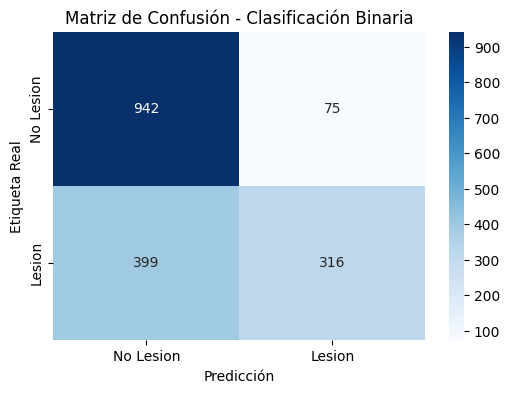

1/1 [==============================] - 0s 32ms/step

Evaluación del modelo multiclase (Tipos de Lesión):
              precision    recall  f1-score   support

        HSIL       0.21      0.12      0.16       113
        LSIL       0.13      0.04      0.06        82
       ASC-H       0.14      0.24      0.17        70
      ASC-US       0.11      0.31      0.16        32
         SCC       0.60      0.32      0.41        19
    Negative       1.00      1.00      1.00        75

    accuracy                           0.32       391
   macro avg       0.36      0.34      0.33       391
weighted avg       0.34      0.32      0.31       391



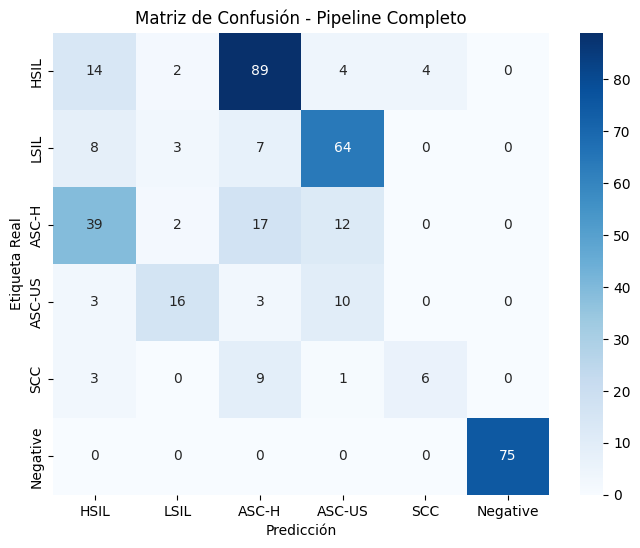

In [24]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cargar los modelos binario y multiclase sin compilar
binary_model = tf.keras.models.load_model('modelosFinales/movileNet_clasificacionBinaria.keras', compile=False)
multi_class_model = tf.keras.models.load_model('modelosFinales/xception_clasificacion5clases.keras', compile=False)

# Definir clases, incluyendo "Negative" como categoría extra para el pipeline completo
lesion_classes = ['HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC', 'Negative']
binary_labels = {'Negative': 0, 'Lesion': 1}

# Configuración de generadores
IMG_HEIGHT, IMG_WIDTH = 96, 96  # Tamaño para el modelo binario
test_dir = 'imagenes_divididas/test'

# Generador de datos para la fase de clasificación binaria
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['0_no_lesion', '1_lesion']
)

# Evaluación binaria
y_pred_binary = (binary_model.predict(test_generator) > 0.45).astype(int).flatten()
y_true_binary = test_generator.classes

# Crear un DataFrame para almacenar las predicciones y las rutas de archivos
binary_results_df = pd.DataFrame({
    'filepath': test_generator.filepaths,
    'true_label': y_true_binary,
    'predicted_label': y_pred_binary
})

# Filtrar imágenes clasificadas como "Lesión" por el modelo binario para pasar al modelo multiclase
lesion_image_paths = binary_results_df[binary_results_df['predicted_label'] == 1]['filepath'].values

# Mostrar la matriz de confusión y reporte de clasificación del modelo binario
print("Evaluación del modelo binario (Lesión vs No Lesión):")
print(classification_report(y_true_binary, y_pred_binary, target_names=['No Lesion', 'Lesion']))
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=['No Lesion', 'Lesion'], yticklabels=['No Lesion', 'Lesion'])
plt.title('Matriz de Confusión - Clasificación Binaria')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Generador para la clasificación multiclase
IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI = 90, 90  # Tamaño para el modelo multiclase
multi_class_datagen = ImageDataGenerator(rescale=1./255)

# Evaluación multiclase utilizando las imágenes clasificadas como "Lesión"
y_true_multi = []
y_pred_multi = []

for img_path in lesion_image_paths:
    # Determinar la clase verdadera a partir del path
    true_class_name = os.path.basename(os.path.dirname(img_path))
    if true_class_name == 'Negative':
        y_true_multi.append(len(lesion_classes) - 1)  # Índice de "Negative"
        y_pred_multi.append(len(lesion_classes) - 1)  # Asignar a "Negative" si se clasifica incorrectamente
        continue

    # Preprocesar y predecir usando el modelo multiclase
    img_multi = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT_MULTI, IMG_WIDTH_MULTI))
    img_array_multi = tf.keras.preprocessing.image.img_to_array(img_multi)
    img_array_multi = np.expand_dims(img_array_multi, axis=0) / 255.0

    # Predicción con el modelo multiclase
    multi_class_pred = multi_class_model.predict(img_array_multi)
    predicted_class = np.argmax(multi_class_pred, axis=1)[0]
    
    # Obtener el índice de la clase verdadera
    true_class_index = lesion_classes.index(true_class_name)
    y_true_multi.append(true_class_index)
    y_pred_multi.append(predicted_class)

# Evaluación completa del pipeline
print("\nEvaluación del modelo multiclase (Tipos de Lesión):")
print(classification_report(y_true_multi, y_pred_multi, target_names=lesion_classes))
cm_pipeline = confusion_matrix(y_true_multi, y_pred_multi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pipeline, annot=True, fmt='d', cmap='Blues', xticklabels=lesion_classes, yticklabels=lesion_classes)
plt.title('Matriz de Confusión - Pipeline Completo')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()